In [1]:
import distutils.util
import os
import subprocess

In [2]:
import mujoco
mujoco.MjModel.from_xml_string('<mujoco/>')

In [3]:
import time
import itertools
import numpy as np

In [4]:
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

xml形式でモデルをもつ

In [5]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# 赤い箱と緑の球
model = mujoco.MjModel.from_xml_string(xml)

In [6]:
#ジオメトリの数
model.ngeom

2

In [7]:
# ジオメトリの持つ色のリスト
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

In [8]:
#ジオメトリ毎のプロパティ
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

In [9]:
#初期化時に値を指定してないパラメタは適当な初期値が入ってるっぽい
model.geom("red_box")

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 0
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'red_box'
  pos: array([0., 0., 0.])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.346])
  rgba: array([1., 0., 0., 1.], dtype=float32)
  sameframe: array([1], dtype=uint8)
  size: array([0.2, 0.2, 0.2])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([6], dtype=int32)
  user: array([], dtype=float64)
>

In [10]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

In [11]:
# 名前からIDを取得する事も出来る
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

In [12]:
#ID取得はこっちの方が簡単
model.geom("green_sphere").id

1

In [13]:
# 剛体の名前一覧を得る方法
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

mjDataクラスで、時間とそれに依存する一般化座標と一般化速度を持つ
それぞれ、data.time、data.qpos、data.qvel

In [14]:
data = mujoco.MjData(model)
print(data.time, data.qpos, data.qvel)

0.0 [] []


mjDataは世界座標系のオブジェクト位置も持ってるが、FKを解かなければちゃんとした値は持ってない

In [15]:
# 緑球のオフセットが入ってない
data.geom_xpos

array([[0., 0., 0.],
       [0., 0., 0.]])

In [16]:
mujoco.mj_kinematics(model, data) #キネマ解く
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# レンダリング


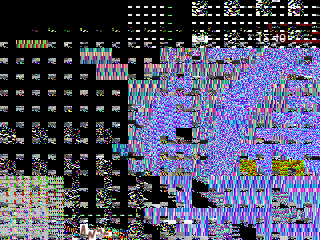

In [17]:
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  media.show_image(renderer.render())

黒いピクセルはなぜ？

答えは 上記と同じ理由で、まずmjDataの値を伝播させる必要があります。つまり、x˙=f(x)を計算する。ここでxは状態である。この関数は実際に必要な以上のことをしますが、計算時間を節約することを気にしない限り、mj_forwardを呼び出すのは良い方法です。

また、ビジュアル・シーンを記述するレンダラーが保持するオブジェクトであるmjvSceneを更新する必要もある。シーンには、物理モデルの一部ではないビジュアル・オブジェクトを含めることができることを後で説明します。


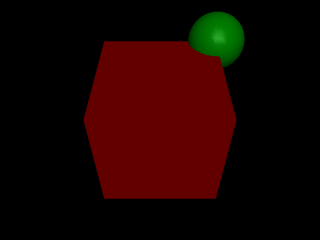

In [18]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())


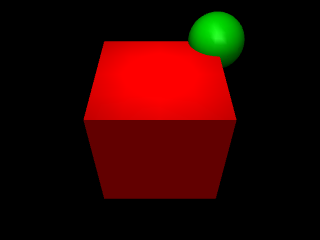

In [19]:
# xml弄って、光源の位置を調整
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())


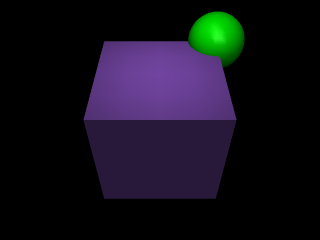

In [20]:
# 箱の色をランダムに変更
model.geom('red_box').rgba[:3] = np.random.rand(3)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [21]:
# 動画の生成
def make_video(model, data, duration, framerate, height = 240, width = 320, scene_option=None, camera=-1):
    frames = []
    with mujoco.Renderer(model, height, width) as renderer:
      while data.time < duration:
        mujoco.mj_step(model, data)#時間を進める
        if len(frames) < data.time * framerate:
            # １枚づつとってフィルムに収めるかんじ
          renderer.update_scene(data, scene_option=scene_option, camera=camera)
          pixels = renderer.render()
          frames.append(pixels)
    return frames
duration = 3.8  # (seconds)
framerate = 60  # (Hz)
mujoco.mj_resetData(model, data)  #状態を初期化
frames = make_video(model, data, duration, framerate)
media.show_video(frames, fps=framerate)#動画の描写

In [22]:
# 回転関節を加えてみる
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# 関節を見せるオプションをTrueにしないと関節は見えない
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
mujoco.mj_resetData(model, data)
frames = make_video(model, data, duration, framerate, scene_option=scene_option)
media.show_video(frames, fps=framerate)

In [23]:
model.opt.timestep

0.002

In [24]:
print('default gravity', model.opt.gravity)
#重力を反対に働かせて遊ぶ
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
frames = make_video(model, data, duration, framerate, scene_option=scene_option)
media.show_video(frames, fps=60)

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


In [25]:
#なんか状態量の値とか見てみる
print('モデル中の関節自由度の数:', model.nv)
print('Time:', data.time)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

モデル中の関節自由度の数: 1
Time: 3.801999999999803
Generalized positions: [1.392]
Generalized velocities: [-3.79]


- <option/>で積分器を4次のルンゲクッタに設定（精度がいいらしい）
- <freejoint/>で6DoFのフリージョイントを追加する。
- <asset/>で床のグリッドマテリアル（見た目）を定義し、それを "plane"geomで参照する
    
- トップの重心を低くするために、"ballast"という不可視で非衝突のgeomを使用します。重心を低くすることは、（直感に反しますが）反転の動作に必要
- 回転状態からシミュレーションを始めるためにkeyframeを保存する
    - Z軸周りの速い回転速度にプラスしてY軸周りの遅い回転を混ぜて、わざとこかせる
<camera>を定義し、update_scene()のcamera引数に名前を渡す


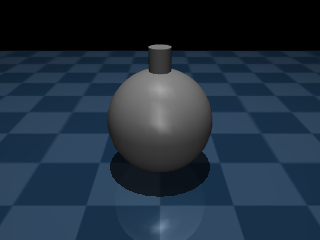

In [26]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, camera="closeup")

  media.show_image(renderer.render())

In [27]:
print('positions', data.qpos)
print('velocities', data.qvel)
#姿勢はクオータニオン表現なのでpositionが七次元になってること注意

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


In [28]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, model.keyframe("spinning").id) # "spinnig"のキーフレームで初期化
frames = make_video(model, data, duration, framerate, camera="closeup")
media.show_video(frames, fps=framerate)

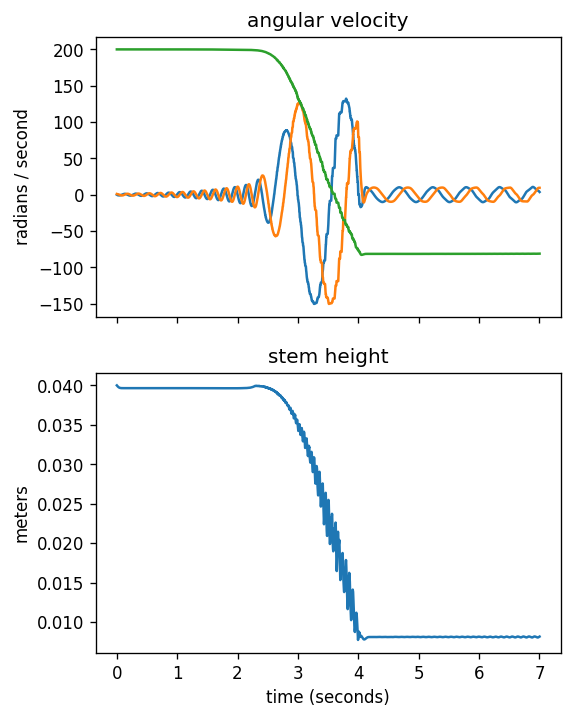

In [29]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, model.keyframe("spinning").id)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2]);

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

- <default>でjointやgeomのローカル設定が作れるっぽい
    - ここでは、jointはヒンジタイプと回転軸の設定、geomはカプセルタイプで、、、みたいな事を決めてる
- カメラを真横からにしてる


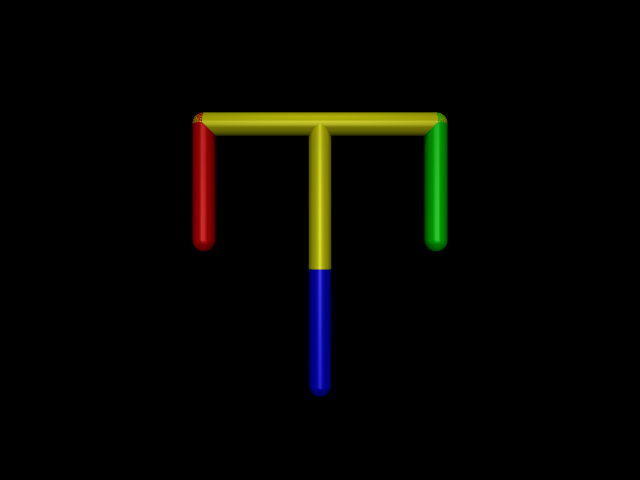

In [30]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
# 画像大きめに
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

シミュレーションとレンダリングにそれぞれどれくらい計算時間がかかっているかを計算

In [31]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:   7.8 μs/step  (128263Hz)
rendering:  1.99e+03 μs/frame (  502Hz)




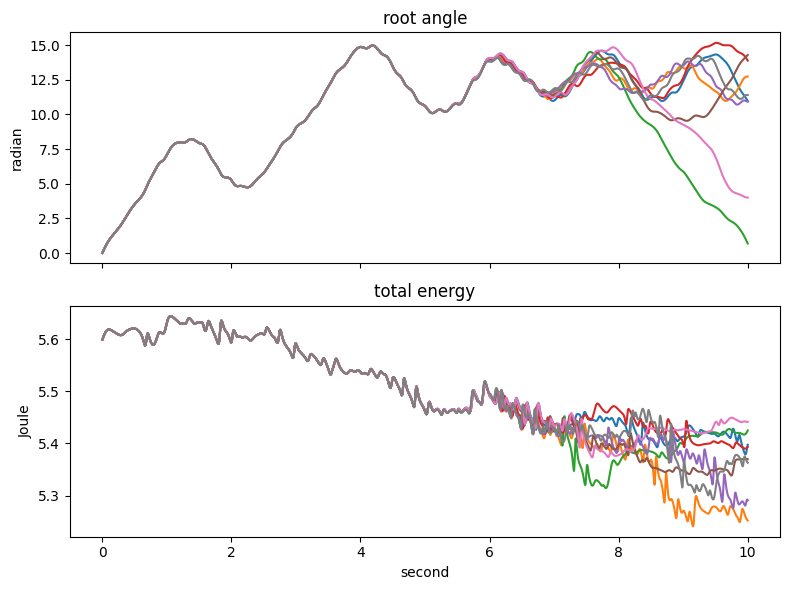

In [32]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos[0]
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

In [33]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


`model.opt.timestep`の値を変えてシミュレーションの周期を変更できる

1000 steps at dt = 10ms
3162 steps at dt = 3.2ms
10000 steps at dt =  1ms
31622 steps at dt = 0.32ms
100000 steps at dt = 0.1ms


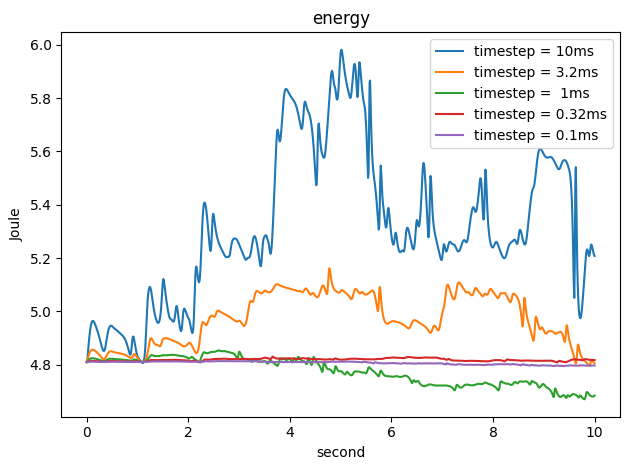

In [34]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

## 接触シミュレーション


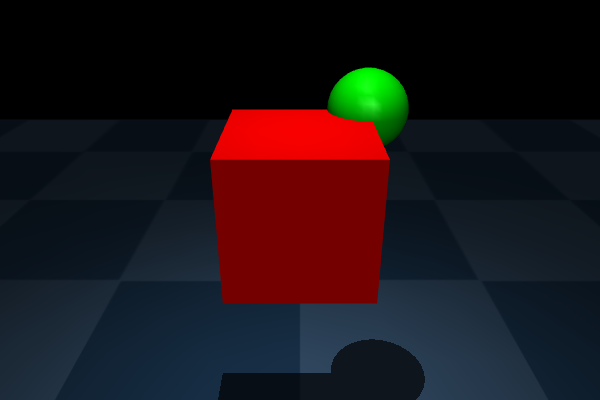

In [35]:
# free joint付きの箱
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
data = mujoco.MjData(model)
height = 400
width = 600

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

- 早送りorスロー動画の作り方
    - 普通はsimのタイムステップと1/fpsを合わせてあげて、1タイムステップ毎に１枚のフレームをとり、sim時間×fps枚のフレームをレンダリングしリアルタイムにする
        - つまり、1フレームの撮影の合間に1/fpsのシミュレーション時間を進める
        - ここで、あえて1フレームの合間に(1/fps)*N 時間を進めると、出来上がる動画はN倍速になる

In [36]:
height = 240
width = 320
duration = 7    # (seconds)
framerate = 30  # (Hz)
n_times_speed = 1/4
n_frames = duration*framerate
frames = []

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True #接触点可視化する
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True #接触力可視化する
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True #スケスケにする

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1 #接触点マーカーの大きさ
model.vis.scale.contactheight = 0.03 #接触点マーカーの厚さ
model.vis.scale.forcewidth = 0.05 #接触力ベクトルの図示の円柱矢印の太さ
model.vis.map.force = 0.3 #接触力ベクトルの長さ

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3) #初期姿勢を乱数で設定

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < (i/framerate)*n_times_speed: #1/4x real time
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "track", options)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=framerate)

### 接触点数とかのとり方

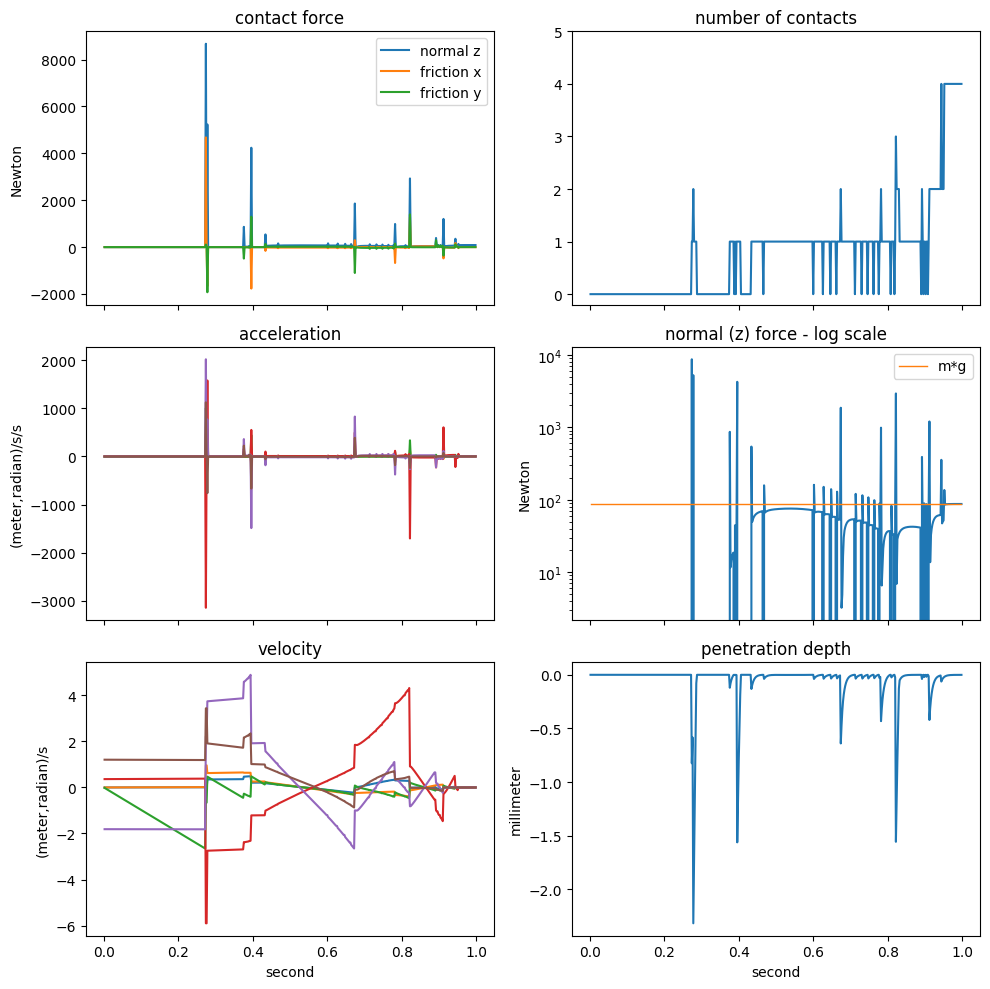

In [37]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon #接触点数
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()

In [38]:
# 摩擦係数を変えた２つのジオメトリを用意
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
duration = 2    # (seconds)
framerate = 30  # (Hz)
n_frames = duration*framerate
height = 300
width = 400

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)

# Simulate and display video.
frames = make_video(model, data, duration, framerate, height=height, width=width, camera="y")

media.show_video(frames, fps=30)

### tendon
空中（世界座標）に"anchor"、箱の角に"hook"をsiteで定義し、

その間をtendonタグを使って腱でつないでいる

箱に"IMU"という名前のsiteを定義し、そこにaccelerometerタグを使って加速度計を埋め込んで

1
['world', 'bat', 'box_and_sphere']



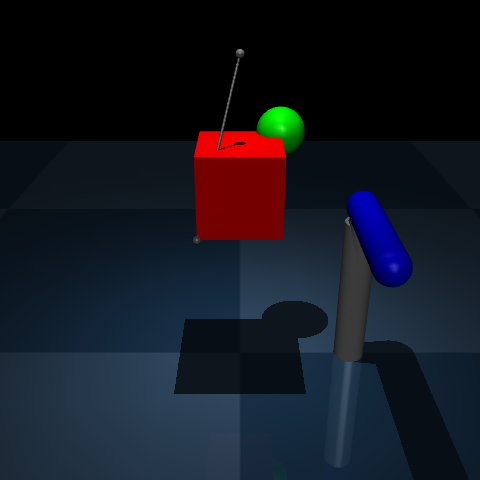

In [39]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>
｝
  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480
print(model.nu)
print([model.body(i).name for i in range(model.nbody)])

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

In [40]:
# model.geom("ground")
print([model.geom(i).name for i in range(model.ngeom)])
print([model.joint(i).name for i in range(model.njnt)])

['floor', 'pole', 'bat', 'red_box', 'green_sphere']
['swing', 'free']


In [41]:
model.actuator("my_motor")

<_MjModelActuatorViews
  acc0: array([16.868])
  actadr: array([-1], dtype=int32)
  actlimited: array([0], dtype=uint8)
  actnum: array([0], dtype=int32)
  actrange: array([0., 0.])
  biasprm: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  biastype: array([0], dtype=int32)
  cranklength: array([0.])
  ctrllimited: array([0], dtype=uint8)
  ctrlrange: array([0., 0.])
  dynprm: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  dyntype: array([0], dtype=int32)
  forcelimited: array([0], dtype=uint8)
  forcerange: array([0., 0.])
  gainprm: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  gaintype: array([0], dtype=int32)
  gear: array([1., 0., 0., 0., 0., 0.])
  group: array([0], dtype=int32)
  id: 0
  length0: array([0.])
  lengthrange: array([0., 0.])
  name: 'my_motor'
  trnid: array([ 0, -1], dtype=int32)
  trntype: array([0], dtype=int32)
  user: array([], dtype=float64)
>

In [42]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []
swing_vel = []
swing_acc = []

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20
#アクチュエータに速度司令を与えている（ここでは１自由度しかないのでスカラ？）ようにも見える（あとの関節速度のプロットみると）
# ただ、上のXML見るとactuatorがmotorになってて、DDモータを指定しているので入力は速度じゃない気もする謎
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.5

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      times.append(data.time)
      sensordata.append(data.sensor('accelerometer').data.copy())
      swing_vel.append(data.joint("swing").qvel[0].copy())
      swing_acc.append(data.joint("swing").qacc[0].copy())
    camera.lookat = data.body('box_and_sphere').subtree_com
    renderer.update_scene(data, camera=camera)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)

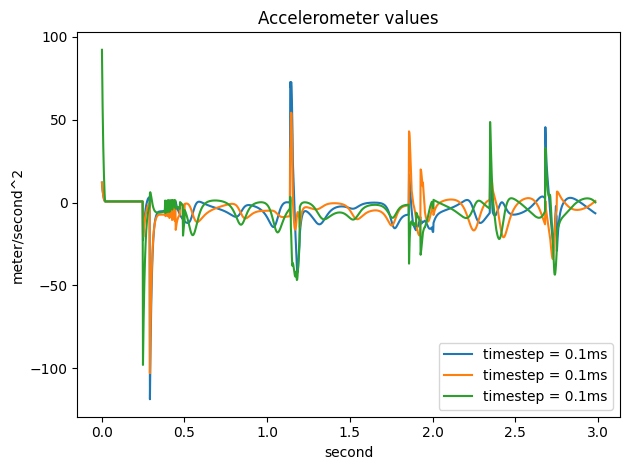

In [43]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

In [44]:
import pandas as pd

<Axes: xlabel='time[s]'>

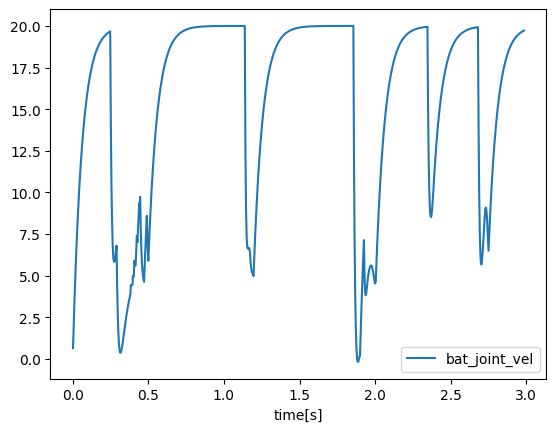

In [45]:
df = pd.DataFrame()
df["time[s]"] = times
df["bat_joint_vel"] = swing_vel
df["bat_joint_acc"] = swing_acc
df.plot("time[s]", "bat_joint_vel")
# df.plot("time[s]", "bat_joint_acc") 

## 色々なレンダリング


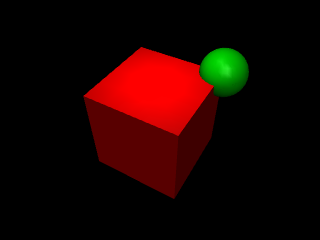

In [46]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())


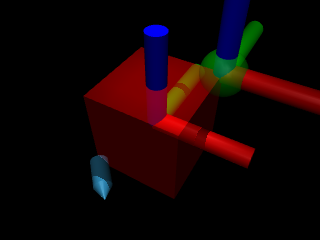

In [47]:
# 座標系とか見せたり透けさせたりするオプション
scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, scene_option=scene_option)
  frame = renderer.render()
  media.show_image(frame)


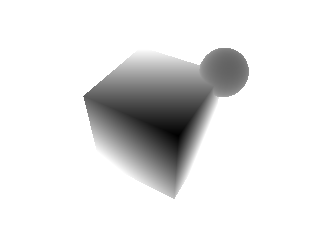

In [48]:
#デプス情報の可視化

with mujoco.Renderer(model) as renderer:
  # update renderer to render depth
  renderer.enable_depth_rendering()

  # reset the scene
  renderer.update_scene(data)

  # depth is a float array, in meters.
  depth = renderer.render()

  # Shift nearest values to the origin.
  depth -= depth.min()
  # Scale by 2 mean distances of near rays.
  depth /= 2*depth[depth <= 1].mean()
  # Scale to [0, 255]
  pixels = 255*np.clip(depth, 0, 1)

  media.show_image(pixels.astype(np.uint8))


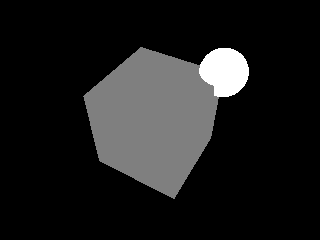

In [49]:
#@オブジェクト毎にセグメンテーションした情報の可視化
## オブジェクト個別に色変える

with mujoco.Renderer(model) as renderer:
  renderer.disable_depth_rendering()

  # update renderer to render segmentation
  renderer.enable_segmentation_rendering()

  # reset the scene
  renderer.update_scene(data)

  seg = renderer.render()

  # Display the contents of the first channel, which contains object
  # IDs. The second channel, seg[:, :, 1], contains object types.
  geom_ids = seg[:, :, 0]
  # Infinity is mapped to -1
  geom_ids = geom_ids.astype(np.float64) + 1
  # Scale to [0, 1]
  geom_ids = geom_ids / geom_ids.max()
  pixels = 255*geom_ids
  media.show_image(pixels.astype(np.uint8))

In [50]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

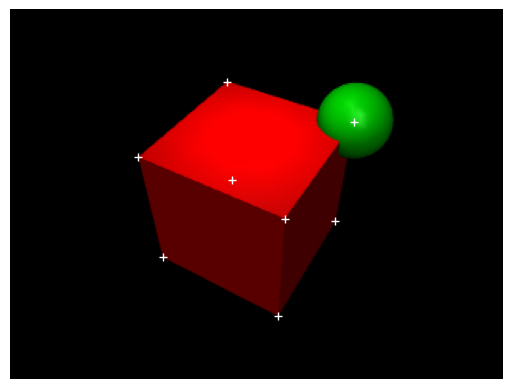

In [51]:
#カメラの座標からオブジェクト位置への投射

with mujoco.Renderer(model) as renderer:
  renderer.disable_segmentation_rendering()
  # reset the scene
  renderer.update_scene(data)

  # Get the world coordinates of the box corners
  box_pos = data.geom_xpos[model.geom('red_box').id]
  box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
  box_size = model.geom_size[model.geom('red_box').id]
  offsets = np.array([-1, 1]) * box_size[:, None]
  xyz_local = np.stack(list(itertools.product(*offsets))).T
  xyz_global = box_pos[:, None] + box_mat @ xyz_local

  # Camera matrices multiply homogenous [x, y, z, 1] vectors.
  corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
  corners_homogeneous[:3, :] = xyz_global

  # Get the camera matrix.
  m = compute_camera_matrix(renderer, data)

  # Project world coordinates into pixel space. See:
  # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
  xs, ys, s = m @ corners_homogeneous
  # x and y are in the pixel coordinate system.
  x = xs / s
  y = ys / s

  # Render the camera view and overlay the projected corner coordinates.
  pixels = renderer.render()
  fig, ax = plt.subplots(1, 1)
  ax.imshow(pixels)
  ax.plot(x, y, '+', c='w')
  ax.set_axis_off()

### 軌跡を描写
ジオメトリの速度を取得してその速度に応じた色のカプセルをジオメトリの位置に追加していくみたいな感じになっている

In [52]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/16  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    # append data to the traces
    positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
    times.append(data.time)
    speeds.append(get_geom_speed(model, data, "green_sphere"))
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      modify_scene(renderer.scene)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

### 背後霊みたいなのを一緒に描写

In [53]:
# Get MuJoCo's standard humanoid model.
# print('Getting MuJoCo humanoid XML description from GitHub:')
# !git clone https://github.com/google-deepmind/mujoco
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

# Load the model, make two MjData's.
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
data2 = mujoco.MjData(model)

# Episode parameters.
duration = 3       # (seconds)
framerate = 60     # (Hz)
data.qpos[0:2] = [-.5, -.5]  # Initial x-y position (m)
data.qvel[2] = 4   # Initial vertical velocity (m/s)
ctrl_phase = 2 * np.pi * np.random.rand(model.nu)  # Control phase
# model.nu で一般化力の次元が取得できるっぽい
ctrl_freq = 1     # Control frequency

# Visual options for the "ghost" model.
vopt2 = mujoco.MjvOption()
vopt2.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # Transparent.
pert = mujoco.MjvPerturb()  # Empty MjvPerturb object
# We only want dynamic objects (the humanoid). Static objects (the floor)
# should not be re-drawn. The mjtCatBit flag lets us do that, though we could
# equivalently use mjtVisFlag.mjVIS_STATIC
catmask = mujoco.mjtCatBit.mjCAT_DYNAMIC

# Simulate and render.
frames = []
with mujoco.Renderer(model, 480, 640) as renderer:
  while data.time < duration:
    # Sinusoidal control signal.
    data.ctrl = np.sin(ctrl_phase + 2 * np.pi * data.time * ctrl_freq)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      # This draws the regular humanoid from `data`.
      renderer.update_scene(data)

      # data2にdataをコピーして、positionをちょっとずらしてmj_forwardを呼んで更新.
      data2.qpos = data.qpos
      data2.qpos[0] += 1.5
      data2.qpos[1] += 1
      mujoco.mj_forward(model, data2)

      # Call mjv_addGeoms to add the ghost humanoid to the scene.
      mujoco.mjv_addGeoms(model, data2, vopt2, pert, catmask, renderer.scene)

      # Render and add the frame.
      pixels = renderer.render()
      frames.append(pixels)

# Render video at half real-time.
media.show_video(frames, fps=framerate/2)

In [54]:
#@title Load the "dominos" model

dominos_xml = """
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>

  <statistic meansize=".01"/>

  <visual>
    <global offheight="2160" offwidth="3840"/>
    <quality offsamples="8"/>
  </visual>

  <default>
    <geom type="box" solref=".005 1"/>
    <default class="static">
      <geom rgba=".3 .5 .7 1"/>
    </default>
  </default>

  <option timestep="5e-4"/>

  <worldbody>
    <light pos=".3 -.3 .8" mode="trackcom" diffuse="1 1 1" specular=".3 .3 .3"/>
    <light pos="0 -.3 .4" mode="targetbodycom" target="box" diffuse=".8 .8 .8" specular=".3 .3 .3"/>
    <geom name="floor" type="plane" size="3 3 .01" pos="-0.025 -0.295  0" material="grid"/>
    <geom name="ramp" pos=".25 -.45 -.03" size=".04 .1 .07" euler="-30 0 0" class="static"/>
    <camera name="top" pos="-0.37 -0.78 0.49" xyaxes="0.78 -0.63 0 0.27 0.33 0.9"/>

    <body name="ball" pos=".25 -.45 .1">
      <freejoint name="ball"/>
      <geom name="ball" type="sphere" size=".02" rgba=".65 .81 .55 1"/>
    </body>

    <body pos=".26 -.3 .03" euler="0 0 -90.0">
      <freejoint/>
      <geom size=".0015 .015 .03" rgba="1 .5 .5 1"/>
    </body>

    <body pos=".26 -.27 .04" euler="0 0 -81.0">
      <freejoint/>
      <geom size=".002 .02 .04" rgba="1 1 .5 1"/>
    </body>

    <body pos=".24 -.21 .06" euler="0 0 -63.0">
      <freejoint/>
      <geom size=".003 .03 .06" rgba=".5 1 .5 1"/>
    </body>

    <body pos=".2 -.16 .08" euler="0 0 -45.0">
      <freejoint/>
      <geom size=".004 .04 .08" rgba=".5 1 1 1"/>
    </body>

    <body pos=".15 -.12 .1" euler="0 0 -27.0">
      <freejoint/>
      <geom size=".005 .05 .1" rgba=".5 .5 1 1"/>
    </body>

    <body pos=".09 -.1 .12" euler="0 0 -9.0">
      <freejoint/>
      <geom size=".006 .06 .12" rgba="1 .5 1 1"/>
    </body>

    <body name="seasaw_wrapper" pos="-.23 -.1 0" euler="0 0 30">
      <geom size=".01 .01 .015" pos="0 .05 .015" class="static"/>
      <geom size=".01 .01 .015" pos="0 -.05 .015" class="static"/>
      <geom type="cylinder" size=".01 .0175" pos="-.09 0 .0175" class="static"/>
      <body name="seasaw" pos="0 0 .03">
        <joint axis="0 1 0"/>
        <geom type="cylinder" size=".005 .039" zaxis="0 1 0" rgba=".84 .15 .33 1"/>
        <geom size=".1 .02 .005" pos="0 0 .01" rgba=".84 .15 .33 1"/>
      </body>
    </body>

    <body name="box" pos="-.3 -.14 .05501" euler="0 0 -30">
      <freejoint name="box"/>
      <geom name="box" size=".01 .01 .01" rgba=".0 .7 .79 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(dominos_xml)
data = mujoco.MjData(model)


In [55]:
#@title Render from fixed camera

duration = 2.5  # (seconds)
framerate = 60  # (Hz)
height = 1024
width = 1440

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, camera='top')
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

In [56]:
#@title Render from moving camera

duration = 3  # (seconds)
height = 1024
width = 1440

# find time when box is thrown (speed > 2cm/s)
throw_time = 0.0
mujoco.mj_resetData(model, data)
while data.time < duration and not throw_time:
  mujoco.mj_step(model, data)
  box_speed = np.linalg.norm(data.joint('box').qvel[:3])
  if box_speed > 0.02:
    throw_time = data.time
assert throw_time > 0

def mix(time, t0=0.0, width=1.0):
  """Sigmoidal mixing function."""
  t = (time - t0) / width
  s = 1 / (1 + np.exp(-t))
  return 1 - s, s

def unit_cos(t):
  """Unit cosine sigmoid from (0,0) to (1,1)."""
  return 0.5 - np.cos(np.pi*np.clip(t, 0, 1))/2

def orbit_motion(t):
  """Return orbit trajectory."""
  distance = 0.9
  azimuth = 140 + 100 * unit_cos(t)
  elevation = -30
  lookat = data.geom('floor').xpos.copy()
  return distance, azimuth, elevation, lookat

def track_motion():
  """Return box-track trajectory."""
  distance = 0.08
  azimuth = 280
  elevation = -10
  lookat = data.geom('box').xpos.copy()
  return distance, azimuth, elevation, lookat

def cam_motion():
  """Return sigmoidally-mixed {orbit, box-track} trajectory."""
  d0, a0, e0, l0 = orbit_motion(data.time / throw_time)
  d1, a1, e1, l1 = track_motion()
  mix_time = 0.3
  w0, w1 = mix(data.time, throw_time, mix_time)
  return w0*d0+w1*d1, w0*a0+w1*a1, w0*e0+w1*e1, w0*l0+w1*l1

# Make a camera.
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)

# Simulate and display video.
framerate = 60  # (Hz)
slowdown = 4    # 4x slow-down
mujoco.mj_resetData(model, data)
frames = []
with mujoco.Renderer(model, height, width) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate * slowdown:
      cam.distance, cam.azimuth, cam.elevation, cam.lookat = cam_motion()
      renderer.update_scene(data, cam)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)